# Table of Content

0) Introduction

1) Importing Libraries

2) Loading the Data

3) Cleaning the Data

4) EDA

5) Feature Engineering

6) Creating and Evaluating ML Models

## Introduction

Elevator predictive maintenance datasets from Huawei German Research Center
Last Updated: 3 years ago (Version 1)

About this Dataset
Elevator Failure Prediction: Predictive Maintenence Dataset
Datasets from a variety of IoT sensors for predictive maintenance in the elevator industry. The data is useful for predictive maintenance of elevators doors in order to reduce unplanned stops and maximize equipment life cycle.

The dataset contains operation data, in the form of time series sampled at 4Hz in high-peak and evening elevator usage in a building (between 16:30 and 23:30). For an elevator car door the system we consider: Electromechanical sensors (Door Ball Bearing Sensor), Ambiance (Humidity), and Physics (Vibration).

Target: Vibration (predict the absolute value of vibration)

Acknowledgements
Cristian Axenie; Stefano Bortoli,

<a href=https://zenodo.org/record/3653909>https://zenodo.org/record/3653909</a>

I got this dataset from:

<a href=https://www.kaggle.com/datasets/shivamb/elevator-predictive-maintenance-dataset>Elevator Predictive Maintenance Dataset</a>

## Importing Libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [2]:
data=pd.read_csv('/kaggle/input/elevator-predictive-maintenance-dataset/predictive-maintenance-dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112001 entries, 0 to 112000
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           112001 non-null  int64  
 1   revolutions  112001 non-null  float64
 2   humidity     112001 non-null  float64
 3   vibration    109563 non-null  float64
 4   x1           112001 non-null  float64
 5   x2           112001 non-null  float64
 6   x3           112001 non-null  float64
 7   x4           112001 non-null  float64
 8   x5           112001 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 7.7 MB


## Cleaning the Data

Checking for Null values:

In [3]:
df=data.copy()
df.isnull().sum().sort_values(ascending=False)

vibration      2438
ID                0
revolutions       0
humidity          0
x1                0
x2                0
x3                0
x4                0
x5                0
dtype: int64

- Since the **vibration** is our target variable it's not acceptable to have null values so the best approach is to drop null values

In [4]:
df=df.dropna(subset=['vibration'])

Checking for Duplicated rows:

In [5]:
df.duplicated().sum()

0

- No Duplicated rows found.

In [6]:
#We don't need Id for our analysis:
df.drop(columns=['ID'],inplace=True)

## EDA

In [7]:
#Let's check for unique values
for i in df.columns:
    print(f'{i}: {df[i].nunique()}')

revolutions: 47106
humidity: 3002
vibration: 9020
x1: 47909
x2: 45673
x3: 83432
x4: 47106
x5: 3002


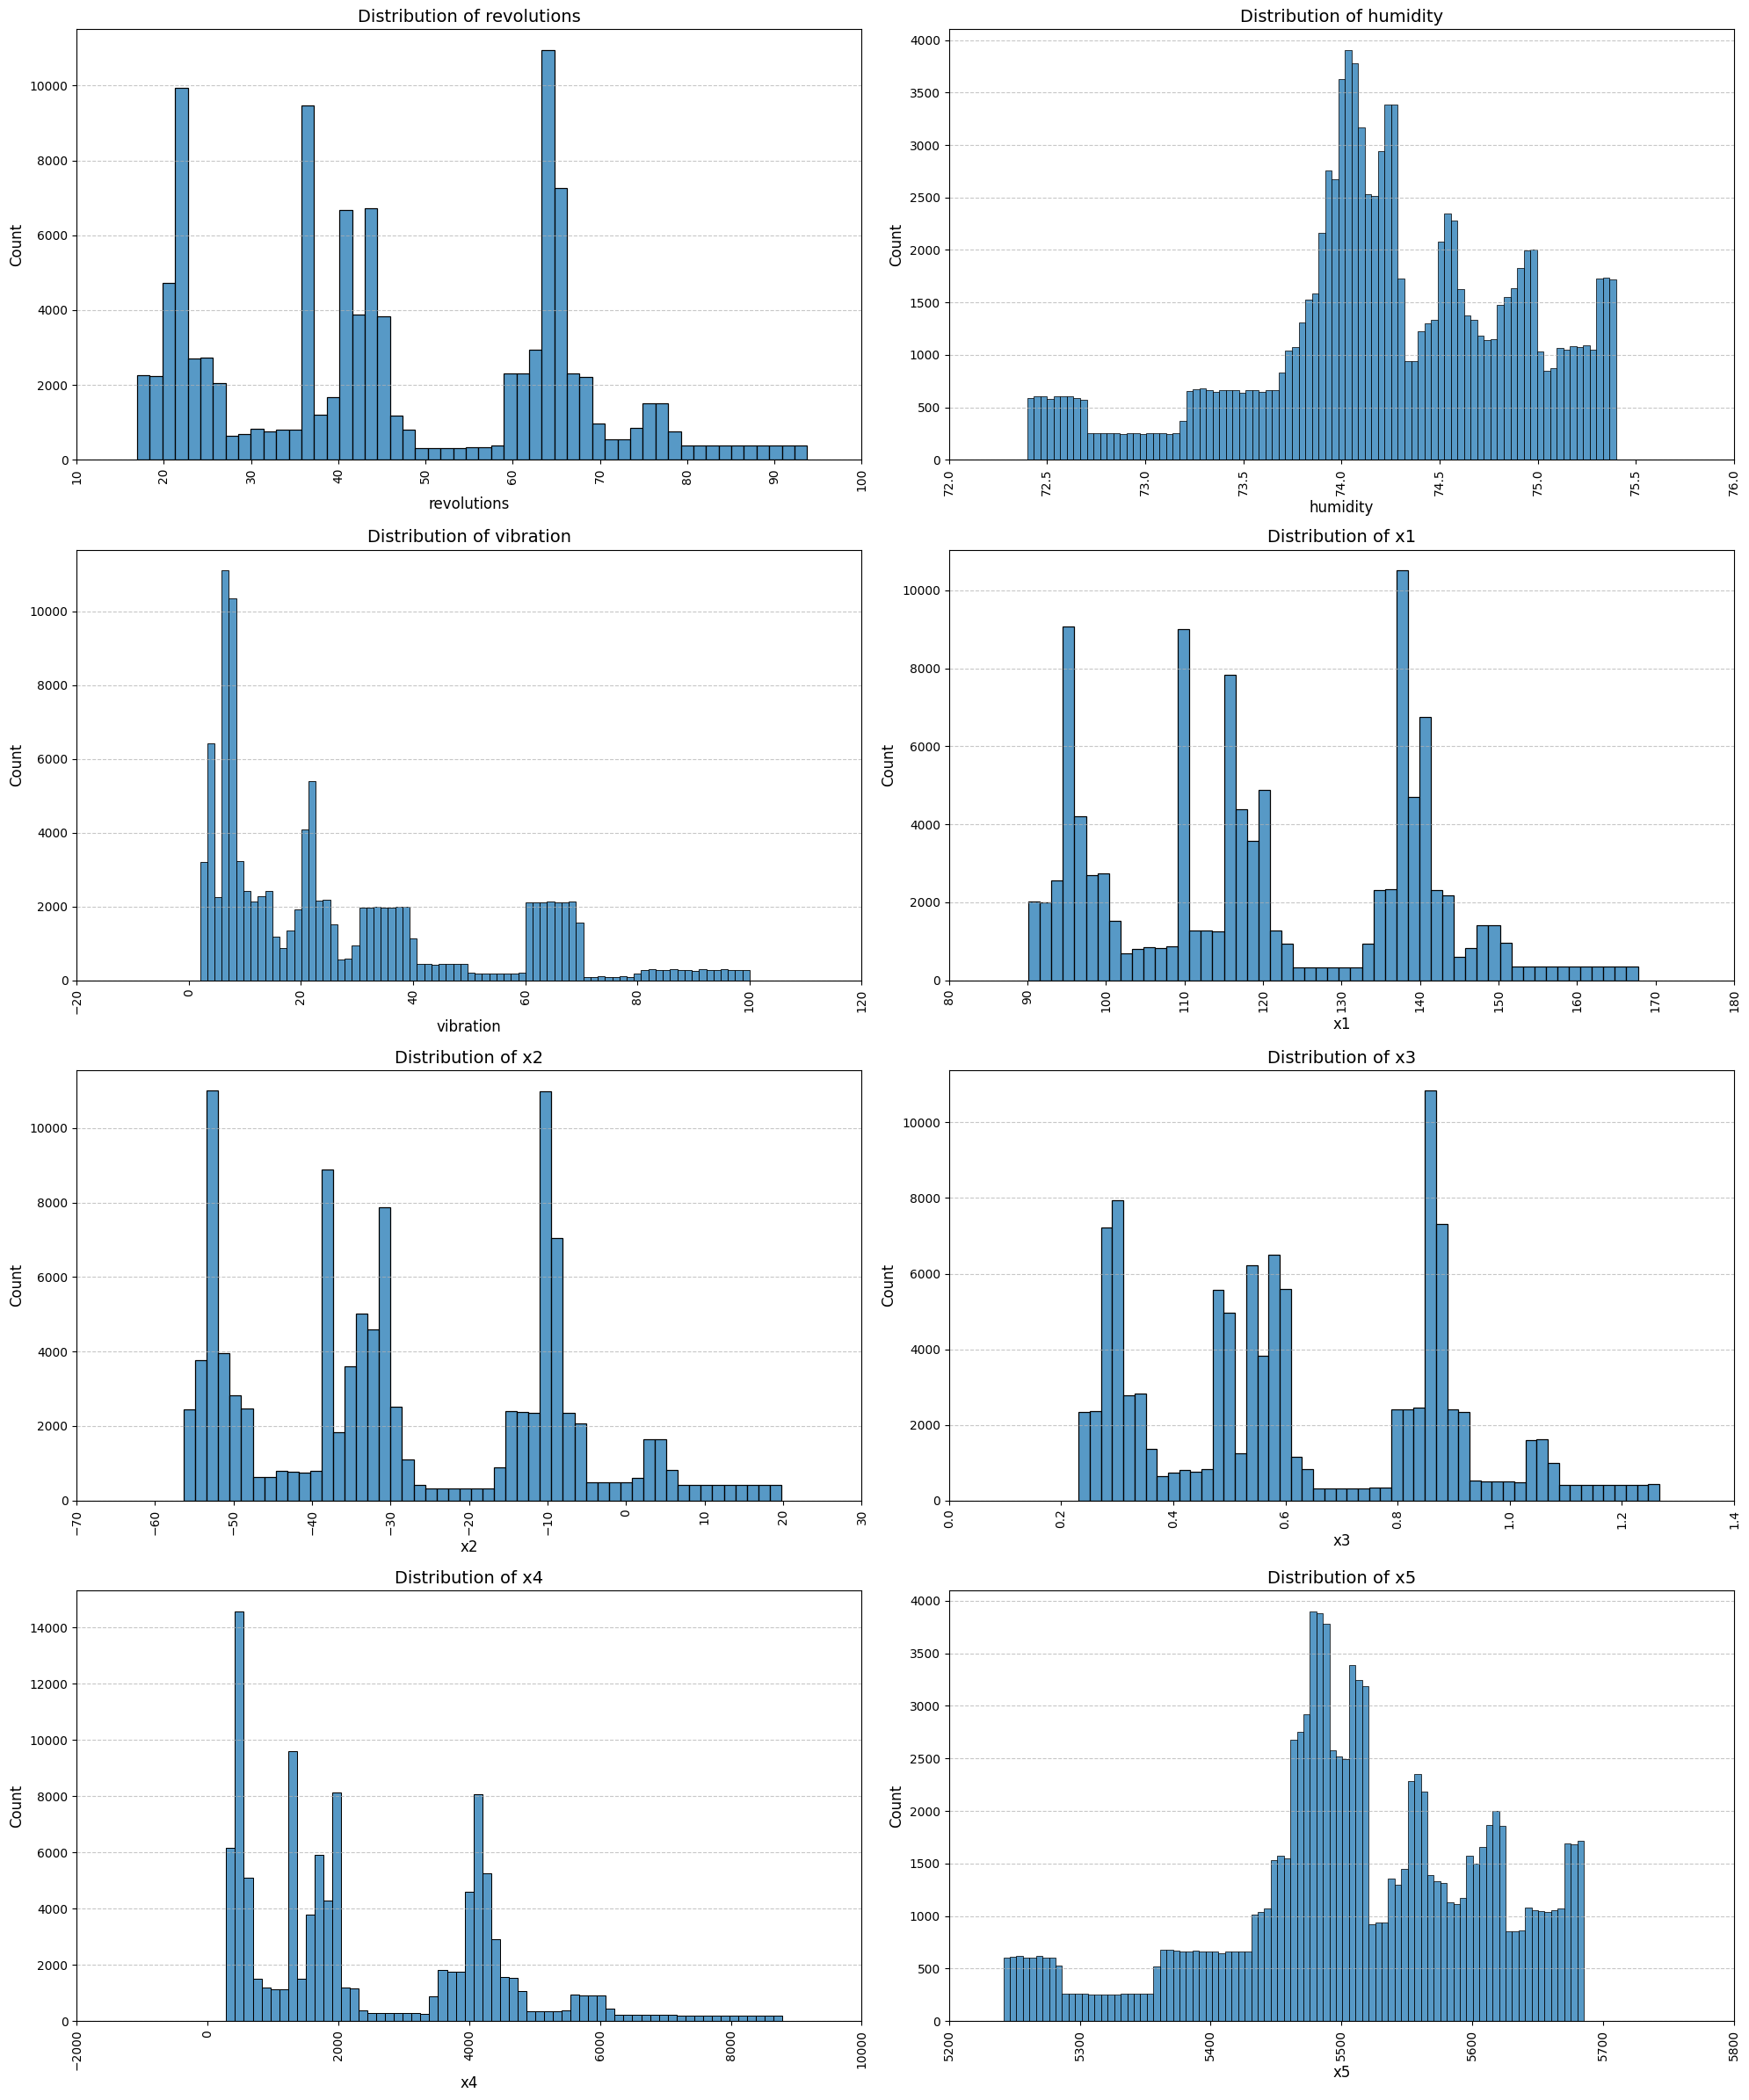

In [8]:

num_columns=2
num_rows=(len(df.columns)+1)//num_columns

fig,axes=plt.subplots(num_rows,num_columns,figsize=(20,num_rows * 6))
axes=axes.flatten()

for i , col in enumerate(df.columns):
    ax=axes[i]
    sns.histplot(data=df,x=col,ax=ax)
    
    ax.set_title(f'Distribution of {col}',fontsize=14)
    ax.set_xlabel(col,fontsize=12)
    ax.set_ylabel('Count',fontsize=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.grid(axis='y',alpha=0.7,linestyle='--')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

- Given the distinct peaks in the distribution of data, certain sensor values appear frequently at specific points.
- Applying **clustering techniques** such as **K-Means, Gaussian Mixture Models (GMM), or DBSCAN** may help identify hidden patterns and group similar sensor behaviors.
- Using models that can leverage **non-linear relationships** and **time-dependent patterns**—such as **Random Forest, XGBoost, or LSTMs**—may improve predictive accuracy.

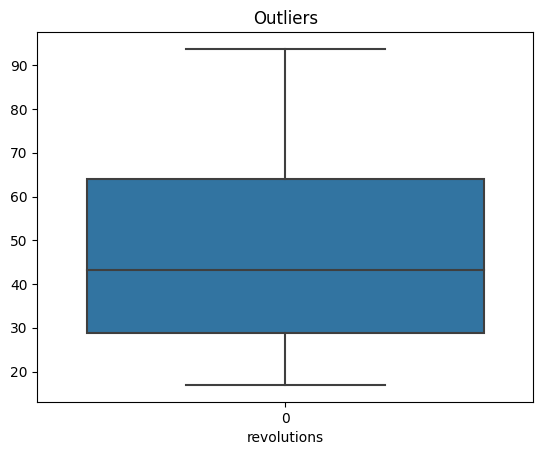

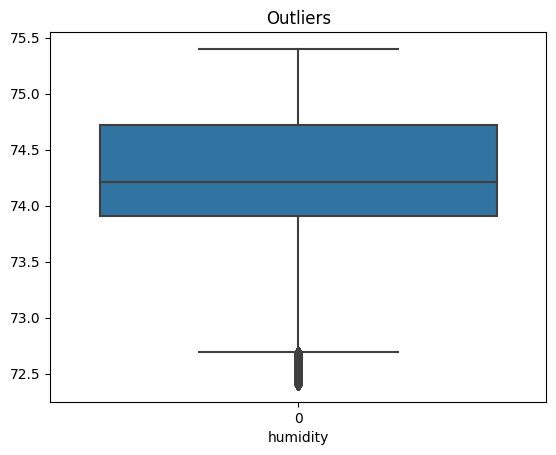

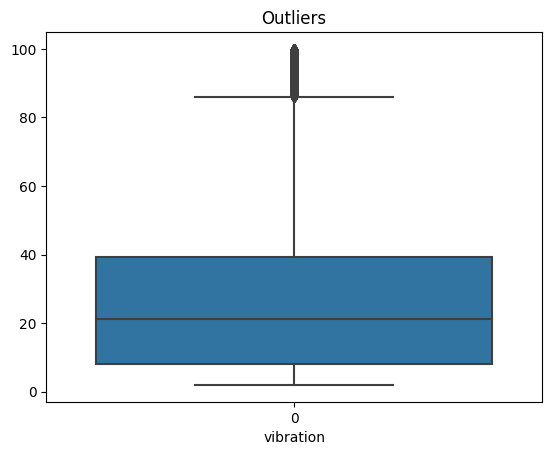

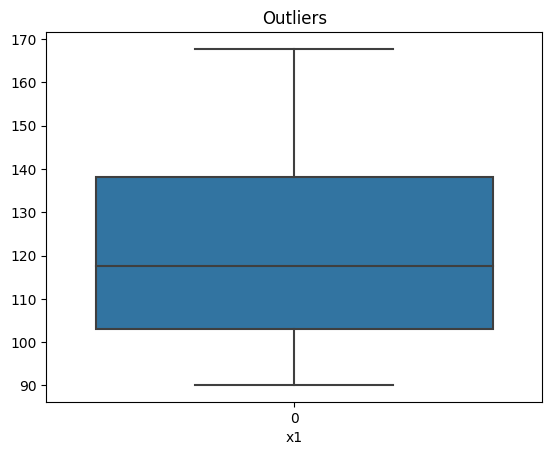

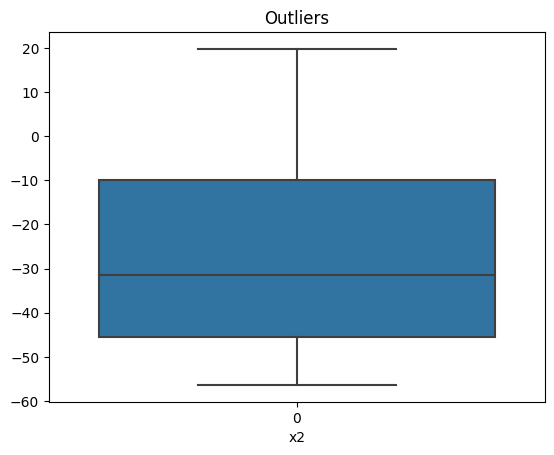

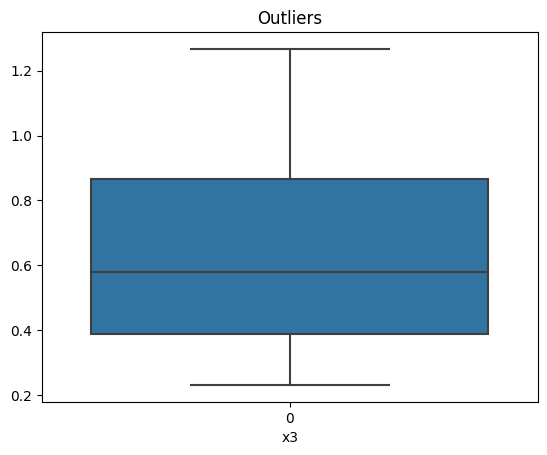

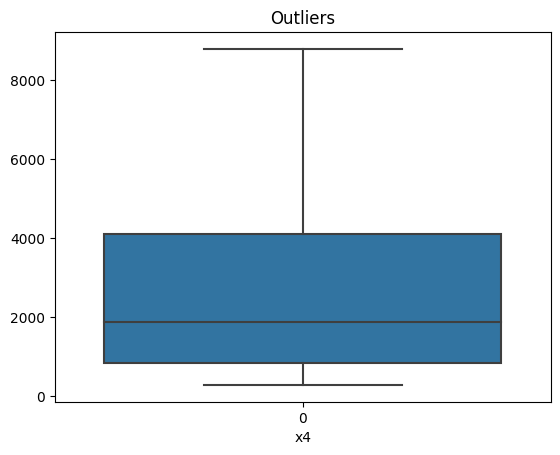

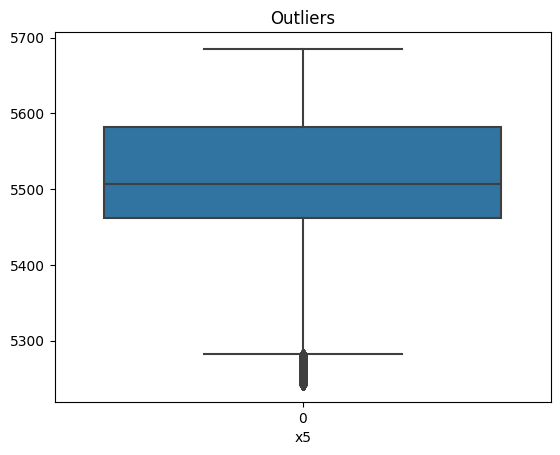

In [9]:
for i in df.columns:
    plt.figure()
    sns.boxplot(df[i])
    plt.title('Outliers')
    plt.xlabel(i)
    plt.show()

- Outliyers are detected and need to be fixed.

In [10]:
for i in df.columns:
    print(f'{i} : {np.round(df[i].skew(),3)}')

revolutions : 0.223
humidity : -0.527
vibration : 0.987
x1 : 0.164
x2 : 0.284
x3 : 0.27
x4 : 0.793
x5 : -0.502


- skewness of the data is not so much but still we need to take care of.

- skewness of the data is not so much but still we need to take care of.

Checking for correlations:

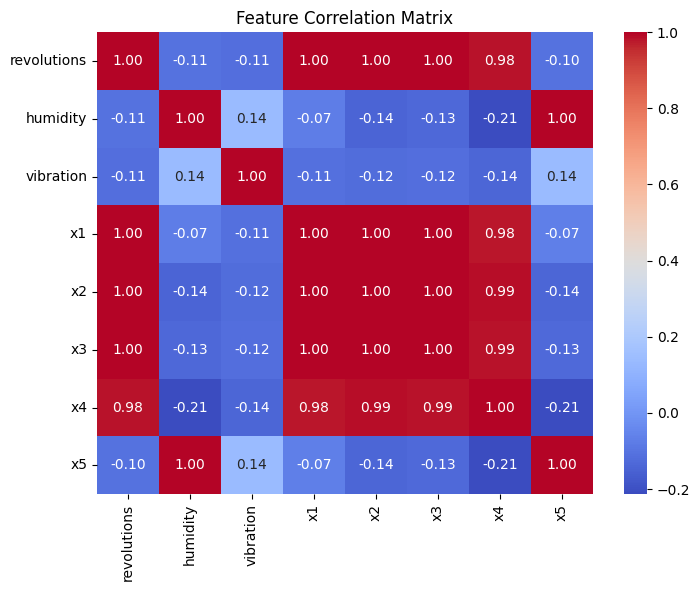

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### Observations from the Correlation Analysis

- **Revolutions** exhibit a very high correlation with sensors **x1** to **x4**, with a coefficient close to **1.0**, indicating a strong linear relationship.
- **Humidity** has a perfect correlation (**1.0**) with sensor **x5**, suggesting that their values move in exact synchronization.
- **Vibration** shows the weakest correlation with other features, implying minimal linear dependence on the sensor readings.
- Sensors **x1** to **x4** have a strong positive correlation with each other, reflecting similar trends in their measurements.

## Feature Engineering

Elevator doors don't just fail instantly.past sensor readings help predict future vibrations. Lag features capture historical trends:

vibration_lag_1: Previous step's vibration value.

vibration_lag_2: Two steps back.

In [13]:
df["vibration_lag_1"] = df["vibration"].shift(1)
df["vibration_lag_2"] = df["vibration"].shift(2)

Raw sensor data is often noisy. Using rolling averages helps smooth fluctuations:

Moving averages detect slow-building faults over time.

Exponential moving average (EMA) prioritizes recent values.

In [14]:
df["rolling_vibration"] = df["vibration"].rolling(window=10).mean()
df["ema_vibration"] = df["vibration"].ewm(span=10, adjust=False).mean()

Since humidity and x5 are perfectly correlated, keeping both adds redundancy.

In [15]:
df["humidity_x5_interaction"] = df["humidity"] * df["x5"]
df.drop(columns=["x5"], inplace=True)  # Drop one of them

In [16]:
# Select highly correlated sensor features
features_to_reduce = ["x1", "x2", "x3", "x4"]

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features_to_reduce])

# Apply PCA to reduce dimensions
pca = PCA(n_components=2)  # Reduce to 2 principal components
df_pca = pca.fit_transform(df_scaled)

# Add PCA features to the original dataset
df["PCA1"] = df_pca[:, 0]
df["PCA2"] = df_pca[:, 1]

# Drop the original highly correlated features
df.drop(columns=features_to_reduce, inplace=True)
print("PCA applied. Reduced redundant sensor features.")

PCA applied. Reduced redundant sensor features.


## Preprocessing

Splitting the Data:

In [17]:
X=df.drop(columns=['vibration'])
y=df['vibration']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

Preprocess the Data:

In [18]:
data_pipeline=make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

data_columns=df.drop(columns=['vibration']).columns
preprocessor=ColumnTransformer(
    [
        ('data_trans',data_pipeline,data_columns)
    ]
)

X_processed=preprocessor.fit_transform(X_train)
X_processed_df=pd.DataFrame(X_processed,columns=preprocessor.get_feature_names_out())


## Create and Evaluate ML Models

In [19]:
sgd_reg=make_pipeline(
    preprocessor,
    SGDRegressor(random_state=42)
)

In [20]:
param_grid = {
    'sgdregressor__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdregressor__alpha': [0.0001, 0.001, 0.01, 0.1],
    
}

grdi_search=GridSearchCV(sgd_reg,param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error',verbose=1,n_jobs=-1)

grdi_search.fit(X_train,y_train)

print(f'sgd_reg best params: {grdi_search.best_params_}')
print(f'sgd_reg best score: {-grdi_search.best_score_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
sgd_reg best params: {'sgdregressor__alpha': 0.0001, 'sgdregressor__penalty': 'l1'}
sgd_reg best score: 8.36373498644983


In [21]:
sgd_reg.set_params(**grdi_search.best_params_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('data_trans',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['revolutions', 'humidity', 'vibration_lag_1', 'vibration_lag_2',
       'rolling_vibration', 'ema_vibration', 'humidity_x5_interaction', 'PCA1',
       'PCA2'],
      dtype='object'))])),
                ('sgdregressor', SGDRegressor(penalty='l1', random_state=42))])

In [22]:
train_sizes, train_scores, test_scores = learning_curve(
    sgd_reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)


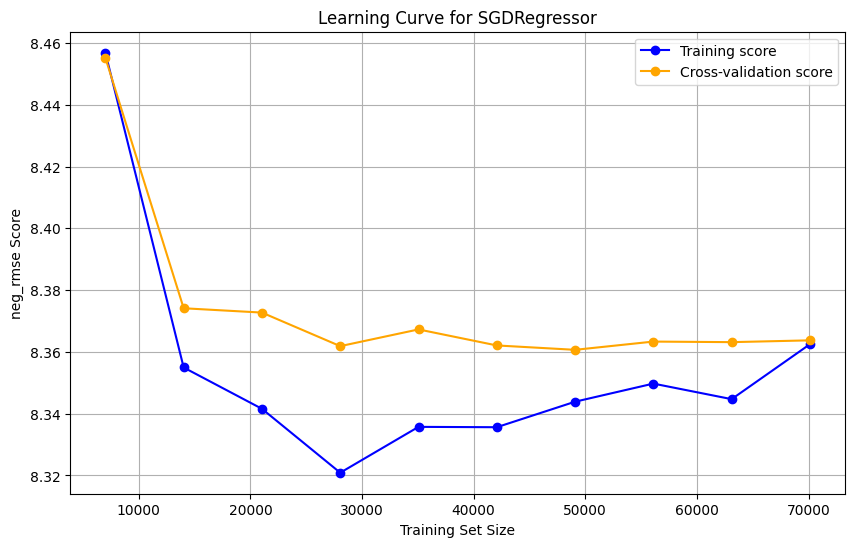

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for SGDRegressor')
plt.xlabel('Training Set Size')
plt.ylabel('neg_rmse Score')
plt.legend()
plt.grid()
plt.show()

In [32]:
xgboost_reg=make_pipeline(
    preprocessor,
    xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
)

In [33]:
param_dist = {
    'xgbregressor__n_estimators': [50, 100, 200, 300], 
    'xgbregressor__max_depth': [3, 5, 7, 10], 
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.3],  
    'xgbregressor__subsample': [0.6, 0.8, 1.0],  
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__gamma': [0, 0.1, 0.5, 1]  
}

random_search = RandomizedSearchCV(
    xgboost_reg,
    param_distributions=param_dist,
    n_iter=20,  
    cv=5,  
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Best Parameters: {'xgbregressor__subsample': 1.0, 'xgbregressor__n_estimators': 300, 'xgbregressor__max_depth': 10, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__gamma': 0.1, 'xgbregressor__colsample_bytree': 1.0}
Best Score: -2.2680981908938223


In [34]:
tree_reg=make_pipeline(
    preprocessor,
    DecisionTreeRegressor(random_state=42)
)

In [35]:
param_grid = {
    'decisiontreeregressor__max_depth': [None, 5, 10, 20],
    'decisiontreeregressor__min_samples_split': [2, 5, 10],
    'decisiontreeregressor__min_samples_leaf': [1, 5, 10],
}

grid_search=GridSearchCV(tree_reg,param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error',verbose=1,n_jobs=-1)

grid_search.fit(X_train,y_train)

print(f'tree_reg best params: {grid_search.best_params_}')
print(f'tree_reg best score: {-grid_search.best_score_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
tree_reg best params: {'decisiontreeregressor__max_depth': None, 'decisiontreeregressor__min_samples_leaf': 1, 'decisiontreeregressor__min_samples_split': 5}
tree_reg best score: 2.242711976838956


In [36]:
tree_reg.set_params(**grid_search.best_params_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('data_trans',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['revolutions', 'humidity', 'vibration_lag_1', 'vibration_lag_2',
       'rolling_vibration', 'ema_vibration', 'humidity_x5_interaction', 'PCA1',
       'PCA2'],
      dtype='object'))])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(min_samples_split=5, random_state=42))])

In [37]:
train_sizes, train_scores, test_scores = learning_curve(
    tree_reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)


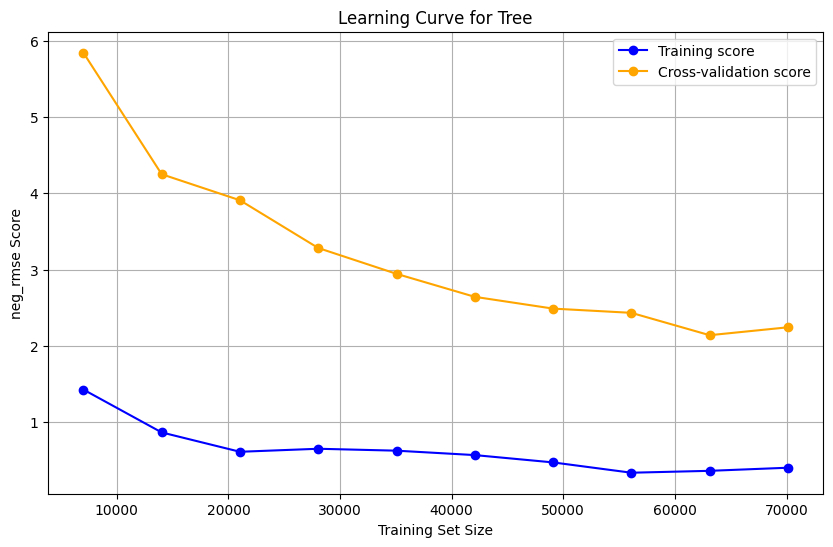

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for Tree')
plt.xlabel('Training Set Size')
plt.ylabel('neg_rmse Score')
plt.legend()
plt.grid()
plt.show()

In [39]:
rnd_reg=make_pipeline(
    preprocessor,
    RandomForestRegressor(random_state=42)
)

In [40]:
param_dist = {
    'randomforestregressor__n_estimators': np.arange(50, 250, 100),       
    'randomforestregressor__max_depth': [None, 10, 20],              
    'randomforestregressor__min_samples_split': [2, 5],             
    'randomforestregressor__min_samples_leaf': [1, 2]                 
}

random_search = RandomizedSearchCV(rnd_reg, param_dist, n_iter=10, cv=3, n_jobs=-1,verbose=1, scoring='neg_root_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train) 

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score): {random_search.best_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'randomforestregressor__n_estimators': 150, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': None}
Best Score): -1.6174849933328248


In [43]:
rnd_reg.set_params(**random_search.best_params_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('data_trans',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['revolutions', 'humidity', 'vibration_lag_1', 'vibration_lag_2',
       'rolling_vibration', 'ema_vibration', 'humidity_x5_interaction', 'PCA1',
       'PCA2'],
      dtype='object'))])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=150, random_state=42))])

In [44]:
train_sizes, train_scores, test_scores = learning_curve(
    rnd_reg, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

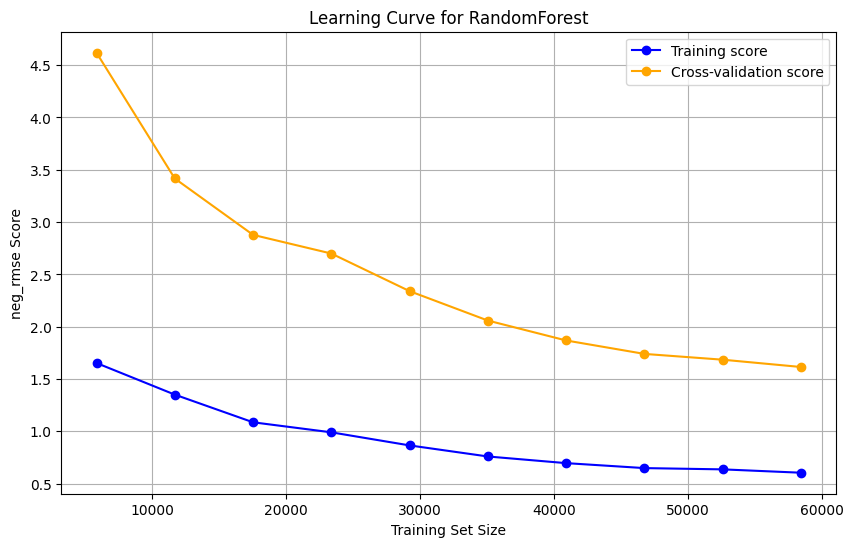

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for RandomForest')
plt.xlabel('Training Set Size')
plt.ylabel('neg_rmse Score')
plt.legend()
plt.grid()
plt.show()

Testing the best model:

In [49]:
#The best mdoel is rnd_reg:

rnd_test_scores=-cross_val_score(rnd_reg,X_test,y_test,cv=3,scoring='neg_root_mean_squared_error')
print(pd.Series(rnd_test_scores).describe())

count    3.000000
mean     3.513044
std      0.154970
min      3.401024
25%      3.424615
50%      3.448206
75%      3.569054
max      3.689903
dtype: float64
